# Gaussian Process Regression

Testing fully Bayesian GP using Pyro for estimating uncertainties in model hyper-parameters.

In [1]:
# Set up local project directory path
from pathlib import Path
from tqdm.notebook import tqdm
import sys

project_src = Path('../src').resolve().as_posix()
sys.path.insert(0, project_src)

# try:
#     import lib.config
# except Exception:
#     raise Exception("Issue with dynamic import")

# config = lib.config.read_config()
# pwd = Path(config["pwd"])
src = Path('../output')

In [2]:
# Import modules needed for the rest of the notebook
import numpy as np
import pandas as pd

from scipy import fft
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Pytorch + GP + Pyro
import torch, gpytorch, pyro

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks', 
    {
        'axes.grid': True, 
        'axes.linewidth': '1',
        'grid.color': '0.5',
        'grid.linestyle': u':',
        'legend.frameon': True,
    })
xkcd = sns.xkcd_rgb


rc_fonts = {
    "font.family": "serif",
    "font.size": 15,
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{libertine} \usepackage[libertine]{newtxmath}",
}
mpl.rcParams.update(rc_fonts)

In [4]:
# CUDA setup
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

if device.type == 'cuda':
    print(f"Using {torch.cuda.get_device_name(0)}")
else:
    print(f"Using {device}")

Using cpu


In [5]:
p = Path('../output/slope_CGILS_S6_CLD_KDE_PIECEWISE.pq')
df = pd.read_parquet(p)

In [6]:
y = df.slope.to_numpy()
x = np.arange(len(y))

x_full = torch.tensor(x, dtype=torch.double)
y_full = torch.tensor(y, dtype=torch.double)

x_tr = torch.tensor(x[:700], dtype=torch.double)
y_tr = torch.tensor(y[:700], dtype=torch.double)

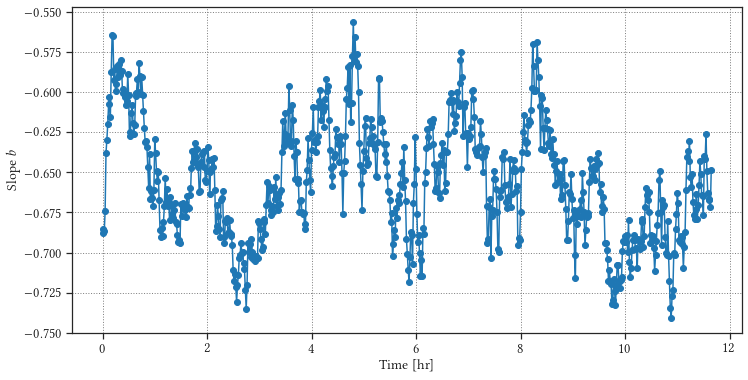

In [7]:
# Plot
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
ax.plot(x_tr / 60, y_tr, 'o-')

ax.set_xlabel("Time [hr]", fontsize=14)
ax.set_ylabel("Slope $b$", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=14)

In [8]:
xf = np.fft.rfft(y_tr.numpy())
yf = np.fft.rfftfreq(y_tr.shape[-1])

xx = 1 / yf
yy = np.abs(xf) ** 2 / len(xx)

_m = np.isfinite(xx) & np.isfinite(yy)

xx = xx[_m]
yy = yy[_m]

/tmp/ipykernel_3635354/3770278785.py:4: RuntimeWarning: divide by zero encountered in true_divide
  xx = 1 / yf


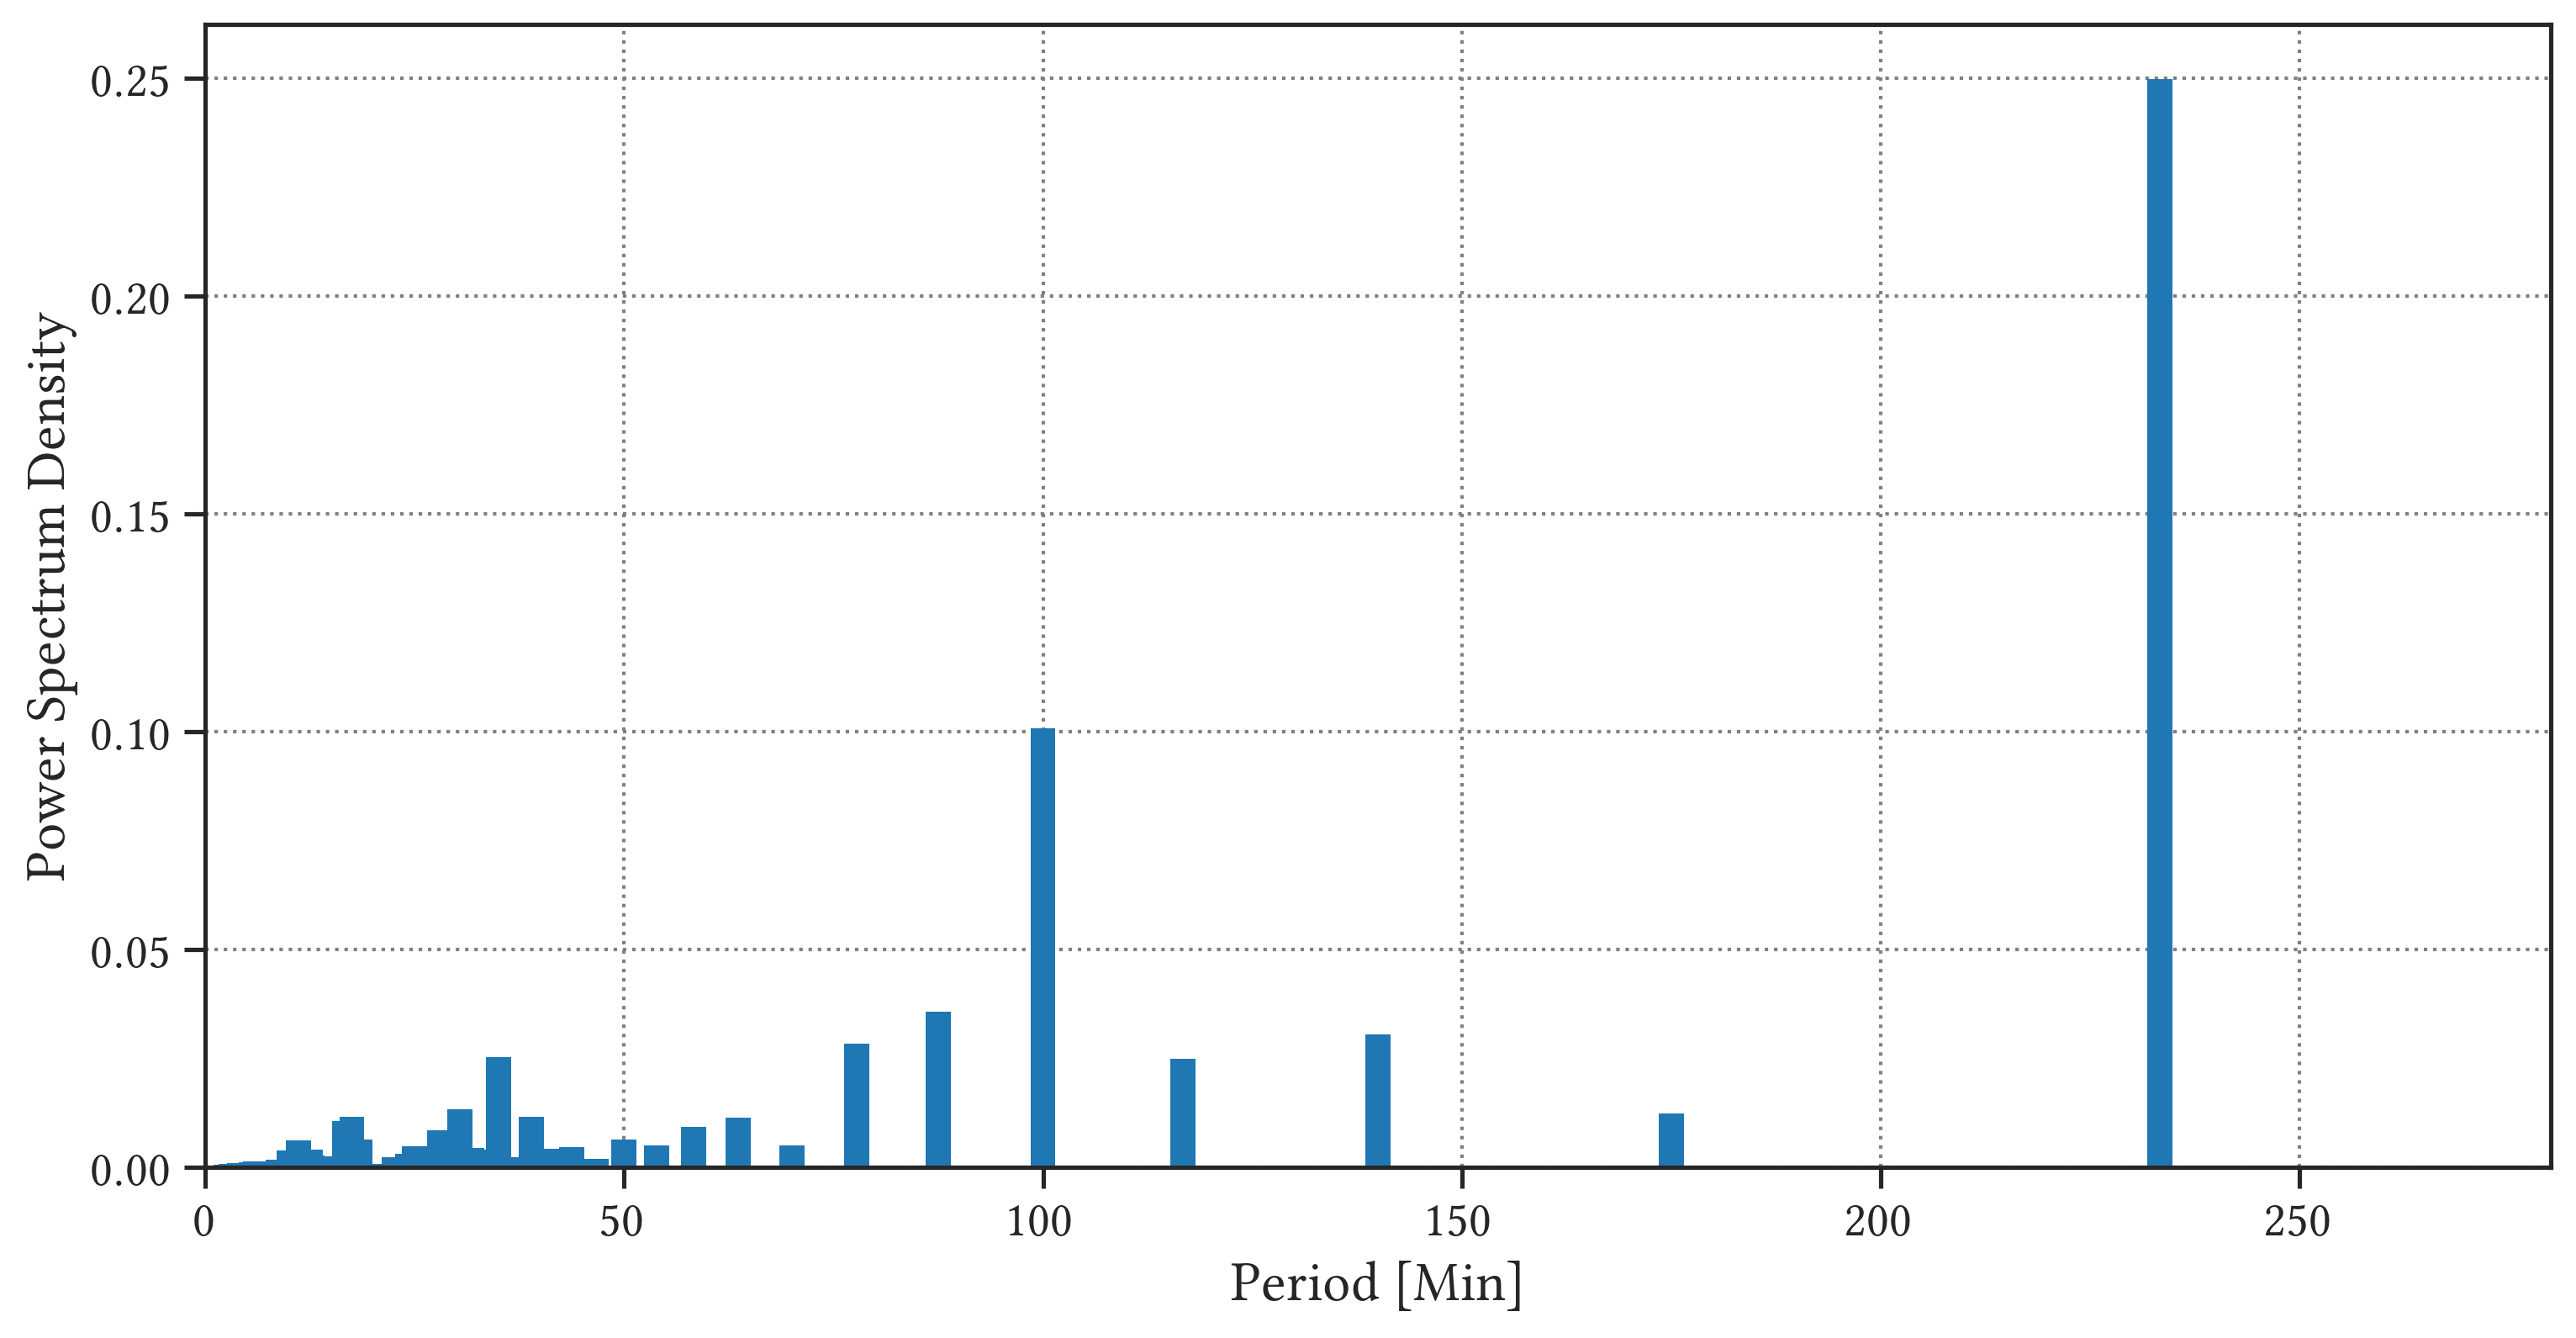

In [9]:
# Plot
fig, ax = plt.subplots(1, 1, figsize = (12, 6), dpi=300)

ax.bar(xx, yy, width=3, edgecolor="none")

ax.set_xlim([0, 280])

ax.set_xlabel("Period [Min]", fontsize=16)
ax.set_ylabel("Power Spectrum Density", fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=14)

In [10]:
if device.type == 'cuda':
    x_tr = x_tr.to(device)
    y_tr = y_tr.to(device)

In [11]:
class SmoothGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_tr, y_tr, likelihood):
        super(SmoothGPModel, self).__init__(x_tr, y_tr, likelihood)
        
        self.mean_module = gpytorch.means.ConstantMean()
        
        self.cov_module = gpytorch.kernels.AdditiveKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()),
        )

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_cov = self.cov_module(x)
        
        return gpytorch.distributions.MultivariateNormal(x_mean, x_cov)

In [12]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint = gpytorch.constraints.GreaterThan(1.e-2),
    noise_prior = gpytorch.priors.NormalPrior(1.e-2, 1)
)
model = SmoothGPModel(x_tr, y_tr, likelihood)

# Initialize kernels
model.cov_module.kernels[0].base_kernel.initialize(
    lengthscale = torch.tensor(30.)
)

model.cov_module.kernels[1].base_kernel.initialize(
    lengthscale = torch.tensor(30.),
    period_length = torch.tensor(90.),
)

model.double()

SmoothGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): NormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-02)
    )
  )
  (mean_module): ConstantMean()
  (cov_module): AdditiveKernel(
    (kernels): ModuleList(
      (0): ScaleKernel(
        (base_kernel): RBFKernel(
          (raw_lengthscale_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
      (1): ScaleKernel(
        (base_kernel): PeriodicKernel(
          (raw_lengthscale_constraint): Positive()
          (raw_period_length_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
    )
  )
)

In [13]:
# Find optimal model hyperparameters
if device.type == 'cuda':
    model = model.to(device)
    likelihood = likelihood.to(device)
    
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([{'params': model.parameters()},], lr=1e-1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

max_iter = 200
losses = []

p_bar = tqdm(range(max_iter))
for i in p_bar:
    optimizer.zero_grad()
    output = model(x_tr)
    loss = -mll(output, y_tr)
    losses += [loss.item()]
    loss.backward()

    p_status = f"{i + 1:3d}/{max_iter:3d} Loss: {loss.item():.3f}"
    p_bar.set_description(p_status)
    
    optimizer.step()

  0%|          | 0/200 [00:00<?, ?it/s]

/tera/users/loh/.local/conda/envs/stats/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1647804203612/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1666.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


In [14]:
# Model parameters
for param_name, param in model.named_parameters():
    print(f"{param_name:42} \t {param.item()}")

likelihood.noise_covar.raw_noise           	 -8.134244790076385
mean_module.constant                       	 -0.6547890119817105
cov_module.kernels.0.raw_outputscale       	 -7.610956731085714
cov_module.kernels.0.base_kernel.raw_lengthscale 	 36.936065814195615
cov_module.kernels.1.raw_outputscale       	 -6.494490125128677
cov_module.kernels.1.base_kernel.raw_lengthscale 	 22.89378995362346
cov_module.kernels.1.base_kernel.raw_period_length 	 95.58484681784448


 The learning rate looks good. It may be a bit too fast (only 200 epochs), but a slower learning rate does not improve the result.

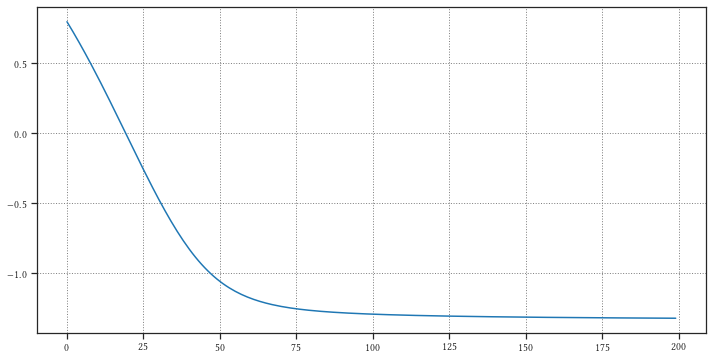

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(np.arange(len(losses)), losses)

In [16]:
dt = 90

# Make predictions by feeding model through likelihood
x_test = torch.arange(x_tr.size(dim=0) + dt, dtype=torch.double)
if device.type == 'cuda':
    x_test = x_test.to(device)

model.eval()
likelihood.eval()

with torch.no_grad():
    observed = likelihood(model(x_test))
    y_mean = observed.mean
    lower, upper = observed.confidence_region()

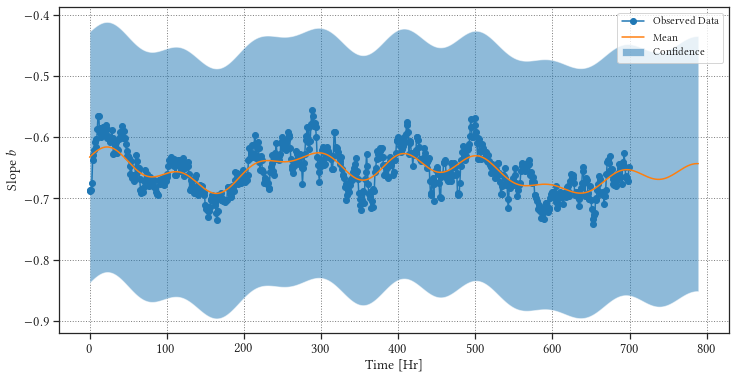

In [17]:
if device.type == 'cuda':
    model = model.cpu()
    likelihood = likelihood.cpu()

    x_tr = x_tr.cpu()
    y_tr = y_tr.cpu()

    x_test = x_test.cpu()
    y_mean = y_mean.cpu()
    lower = lower.cpu()
    upper = upper.cpu()

# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(x_tr, y_tr, 'o-')
ax.plot(x_test, y_mean)
ax.fill_between(x_test, lower, upper, alpha=0.5)

ax.legend(['Observed Data', 'Mean', 'Confidence'])

ax.set_xlabel("Time [Hr]", fontsize=14)
ax.set_ylabel("Slope $b$", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=14)

 It may look like I am being too aggressive with the smoothing, but that's because of the long-term trend in the timeseries and the uncertainty is higher because of it. Of course, I want to remain faithful to the (albeit noisy) data. Reducing the length scales for the two kernels definitely help achieve a much better fit, but it is easy to overfit the dataset while not improving the quality of the regression (and especially the periodicity estimation). Overfitting is definitely more harmful than noise.

 The hyperparameters used aren't meant to be accurate, as they are driven by noisy data. The goal here is to smooth out the noise and local variations to obtain a more general trend. 
 
 At times, depending on the data, GP regression will pick up a long-term trend (e.g. over 2-3 hours). In that case, we will have to repeat the regression until no periodic motions can be observed. For the slope of cloud size distribution, fortunately for me, it is not needed.

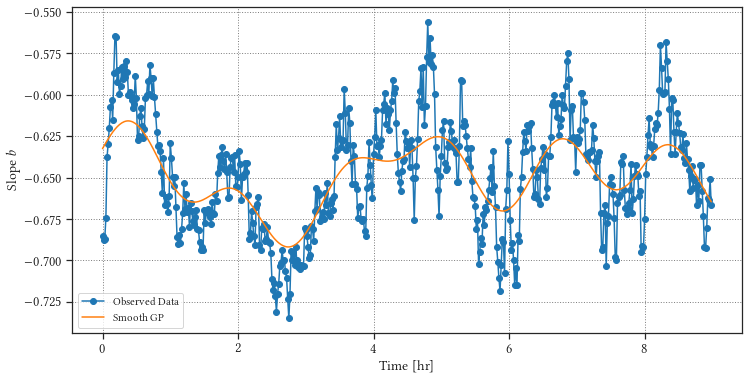

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(x_full[:540] / 60, y_full[:540], 'o-')
ax.plot(x_test[:540] / 60, y_mean[:540])

ax.legend(['Observed Data', 'Smooth GP'])

ax.set_xlabel("Time [hr]", fontsize=14)
ax.set_ylabel("Slope $b$", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=14)

 What do we do with the smooth regression? I used an RBF kernel because it is infinitely differentiable, which is useful. There are a lot of different ways to make a timeseries suitable for regression, but here I find a simply differentiation very powerful in isolating the periodic motion in the timeseries. This also makes the average roughly zero, across, which means that this periodic motion is independent of the general, long-term downward trend seen above. This has an added benefit of making the GP regression much easier, since the only parameter we need to worry about at this point is the periodicity.

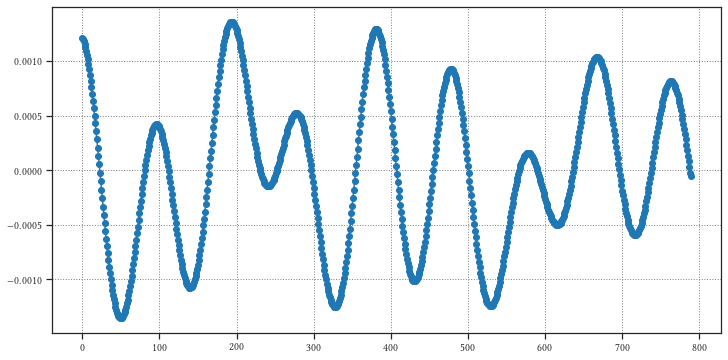

In [19]:
y_grad = np.gradient(y_mean)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(x_test, y_grad, 'o-')